In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 증시 예측 s2s (sequence 2 sequence )

- 데이터 유효성, 누락 검사
- 분포, 상관관계 분석
- 전처리 : X(이동 평균(5일)), Y(다음 5일날 종가) 분리, 정규화
- LinearRegression 점수 측정, tensorflow RNN(s2s model)
- 그래프로 시각화 (역 정규화)

In [4]:
삼성 = '005930'
삼천리자전거 = '024950'
url_base = 'https://finance.naver.com/item/sise_day.nhn?code='
url = url_base + 삼성 +'&page='

In [5]:
page_list = []
max_page = 31 
for page in range(1, max_page):
    tables = pd.read_html(url+str(page))
    page_list.append(tables[0]) # 네이버는 첫번쨰 테이블[0]이 증시데이터 입니다.
len(page_list)

30

In [6]:
df = pd.concat(page_list, axis=0)
df = df.dropna()
df = df.set_index('날짜').drop(columns='전일비')
df = df[::-1]
df.shape

(300, 5)

In [7]:
df.isna().sum().sum()

0

In [8]:
x = df.iloc[:-1] #전날
y = df.iloc[1:]['종가'] #다음날
x.shape, y.shape, np.min(y), np.max(y)

((299, 5), (299,), 37450.0, 48450.0)

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x, y)
model.score(x, y)

0.9119347255188083

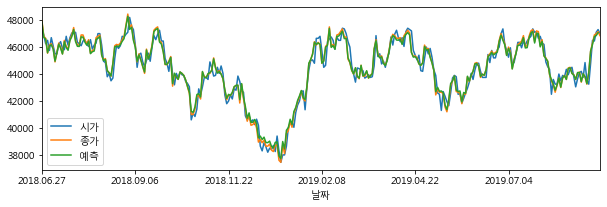

In [10]:
df[['시가', '종가']].plot(figsize=(10, 3))
plt.plot(model.predict(x), label='예측')
plt.legend()

전일비 추가

In [11]:
# 전일비 = 증가 - 다음날 시가
전일비 = df.iloc[1:]['시가']  - df.iloc[:-1]['종가'] 
df['전일비'] = 전일비
df = df.dropna()

이동평균

In [12]:
df_rol = df.rolling(window=5).mean()

In [13]:
df_rol.columns = ['종가_rol', '시가_rol', '고가_rol', '저가_rol', '거래량_rol','전일비_rol']

In [14]:
df_con = pd.concat((df, df_rol), axis=1).dropna()
df_con.head(1)

,종가,시가,고가,저가,거래량,전일비,종가_rol,시가_rol,고가_rol,저가_rol,거래량_rol,전일비_rol
날짜,,,,,,,,,,,,
2018.07.04,46250.0,46700.0,47050.0,46050.0,8776763.0,450.0,46280.0,46410.0,46990.0,46020.0,11946621.2,130.0



지금까지는 데이터에 시간축이 없었습니다

X 는 과거의 5일치 데이터입니다 Y 는 미래의 5일치 데이터입니다 데이터가 10일치가 있었다면 X, Y 1 셋트 만들 수 있습니다 데이터가 11일치가 있었다면 X, Y 2 셋트 만들 수 있습니다

m_seq = m - (x_seq + y_seq) + 1 1 = 10 - ( 5 + 5) + 1 2 = 11 - ( 5 + 5) + 1 285 = 294 -( 5 + 5) + 1

x :  5일치 데이터
y :  다음에 올 하루치 데이터
=> (100 row시) x, y 95set

In [15]:
df_con.shape, len(df_con) 

((294, 12), 294)

In [16]:
x_T = 10
y_T = 5
# X (285, 5, 12), y (285, 5)
x_list = []
y_list = []
for i in range(len(df_con) - (x_T + y_T) + 1): # 285번 반복 
    x = df_con.iloc[i : i+x_T] #[0:5] 과거의 5일
    y = df_con.iloc[i+x_T : i+x_T+y_T]['종가'] #[5:10] 미래의 5일
    x_list.append(x)
    y_list.append(y)
len(x_list), len(y_list)

(280, 280)

In [26]:
X = np.stack(x_list, 0).astype(np.float32)
y = np.stack(y_list, 0).astype(np.float32)
type(X), X.shape, y.shape, X.dtype, y.dtype

(numpy.ndarray, (280, 10, 12), (280, 5), dtype('float32'), dtype('float32'))

In [27]:
np.max(X), np.max(y)

(26254646.0, 48450.0)

In [28]:
from sklearn.preprocessing import MinMaxScaler
X_2d = X.reshape([-1, 12]) # 3d > 2d
y_2d = y.reshape([-1, 1]) # 특징 5개가 아니고 , 특징 1개 이므로 
scaler_x = MinMaxScaler().fit(X_2d)
scaler_y = MinMaxScaler().fit(y_2d)
xn = scaler_x.transform(X_2d)
yn = scaler_y.transform(y_2d)
xn = xn.reshape(X.shape) # 2d > 3d
yn = yn.reshape(y.shape)
xn.shape, yn.shape,  np.min(xn), np.max(xn), np.min(yn), np.max(yn)

((280, 10, 12), (280, 5), 0.0, 1.0, 0.0, 1.0)

In [29]:
import tensorflow.contrib.slim as slim
tf.reset_default_graph()
cell_enc = tf.nn.rnn_cell.GRUCell(100, name='enc')
cell_dec = tf.nn.rnn_cell.GRUCell(100, name='dec')
net = slim.conv1d(xn, num_outputs=10, kernel_size=3)
outputs, last_state = tf.nn.dynamic_rnn(cell_enc, net, dtype=tf.float32)
zero = tf.zeros([len(xn), y_T, 1]) # x와 y 의 시퀀스가 다를 때 
context_vector = last_state # 모든 정보가 이 안에 있습니다
outputs, last_state = tf.nn.dynamic_rnn(cell_dec,zero,initial_state=context_vector)
h = slim.fully_connected(outputs, 1)
h = tf.squeeze(h, axis=-1) #맨 뒤쪽 차원을 제거해라 
cost = tf.reduce_mean((yn - h)**2)
train = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

W0916 14:36:35.980985  3448 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [30]:
for i in range(1000):
    _, c = sess.run([train, cost])    
    #if i%100 == 0: print(i, c)
print(i, c)

999 0.012062076


In [31]:
from sklearn.metrics import r2_score
predict = sess.run(h) # 미래 5일 예측 종가
for i in range(y_T):
    print(i+1, '일 후', r2_score(yn[:, [i]], predict[:, [i]]))

1 일 후 0.8596496688936335
2 일 후 0.7828319313411737
3 일 후 0.7062560730115396
4 일 후 0.6350823202486491
5 일 후 0.5677093432281984


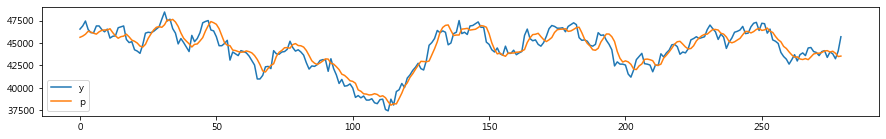

In [32]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [0]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [0]]), label='p')
plt.legend()

In [42]:
for i in range(100000):
    _, c, = sess.run([train, cost])
    if(i%1000)==0: print(i, c, r2_score(yn, sess.run(h)))
print(i, c, r2_score(yn, sess.run(h)))

0 0.14765202 -2.4805396065965124
1000 0.0248085 0.40158016941741836
2000 0.021192791 0.4887699588949672
3000 0.018836364 0.5456004034615326
4000 0.017125417 0.5868673782759279
5000 0.015786435 0.6191645209583961
6000 0.01468778 0.6456659992339456
7000 0.013759942 0.6680474433565773
8000 0.012961504 0.6873079590062376
9000 0.012265748 0.7040915758555689
10000 0.011653543 0.7188597701914293
11000 0.011110433 0.7319614746167733
12000 0.010625343 0.7436634383397149
13000 0.010189493 0.7541776354849936
14000 0.009795895 0.76367268709142
15000 0.009438252 0.7723005060601846
16000 0.009111591 0.7801808535426077
17000 0.008812924 0.7873858428991766
18000 0.008538673 0.7940017865791874
19000 0.008286081 0.800095330961001
20000 0.008052698 0.8057256008066187
21000 0.007836207 0.8109482993692101
22000 0.0076349378 0.8158037461680916
23000 0.007447477 0.8203261730353227
24000 0.0072723175 0.824551745895156
25000 0.007108373 0.8285068580421494
26000 0.0069546998 0.8322141111734669
27000 0.006810262

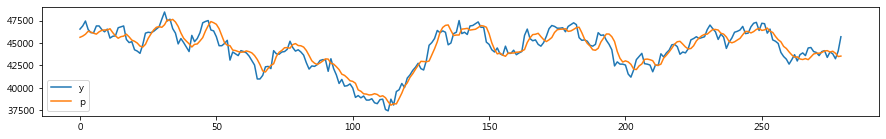

In [35]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [0]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [0]]), label='p')
plt.legend()

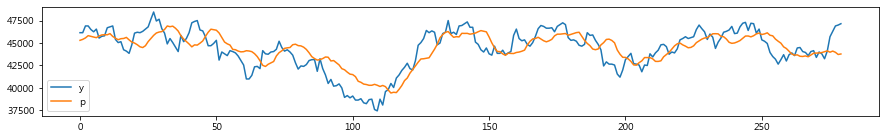

In [33]:
plt.figure(figsize=(15,2))
plt.plot(scaler_y.inverse_transform(yn[:, [4]]), label='y')
plt.plot(scaler_y.inverse_transform(predict[:, [4]]), label='p')
plt.legend()